<a href="https://colab.research.google.com/github/r0cd7b/DSAC/blob/master/Lab7_Cats_And_Dogs_Transfer_Rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 전이학습 고양이 강아지 구분
> - https://subinium.github.io/Keras-5-2/
## VGG16 (2014)
- 이미지넷으로 사전 훈련된 네트워크를 사용
- 1000개의 객체를 구분하는 모델이나, 여기서는 고양이, 강아지 구분에 사용  

## 1) 특성추출 방식
- 합성곱 필터링 영역(convolutional base)를 그대로 사용
- 공통되는 특성만 추출하여 사용한다
- 전결합망 부분은 새로운 데이터 (고양이/강아지)로 학습을 다시 시킨다


## 2) 미세 조정 방식


# 데이터 다운로드

In [1]:
import os, os.path, shutil
import zipfile
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications import VGG16

# VGG16으로 사전학습된 가중치 가져오기
- include_top은 기존의 1000개 전결합망 분류기를 포함할지를 선택

- VGG-16은 ImageNet 데이터베이스의 1백만 개가 넘는 이미지에 대해 훈련된 컨벌루션 신경망입니다. 
- 이 네트워크에는 16개의 계층이 있으며, 이미지를 키보드, 마우스, 연필, 각종 동물 등 1,000가지 사물 범주로 분류할 수 있습니다. 
- 그 결과 이 네트워크는 다양한 이미지를 대표하는 다양한 특징을 학습했습니다. 네트워크의 이미지 입력 크기는 224x224입니다.

In [2]:
conv_base = VGG16(weights = 'imagenet',   # loading 할 weights
                 include_top=False,
                 input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## 세 가지 옵션
### 1) 합성곱 기반을 통과한 출력을 저장한 후 이를 전결합망에 통과
- 데이터 확장은 사용할 수 없다
- 실행이 빠르다

### 2) 모델에 Dense망을 추가하고 학습을 수행
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다


### 3) FInce Tuning (새부조정)


# 데이터 읽기

In [4]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0  84.0M      0 --:--:-- --:--:-- --:--:-- 84.0M


In [5]:
!unzip -q cats_and_dogs_filtered.zip

In [6]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (93.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [7]:
!tree -d .

.
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
└── sample_data

8 directories


In [8]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [9]:
train_dir

'./cats_and_dogs_filtered/train'

# 특성추출만 사용한 모델 (1)
- 데이터 증식은 사용하지 않음
- conv_base layers: 일반적인 학습정보
- final FC layers: 특정한 클라스를 분류하는 기능
- ImageDataGenerator를 사용하여 이미지와 레이블을 생성
- conv_base 모델의 predict를 사용하여 이미지의 특성을 추출
- 마지막 출력의 크기가 (4, 4, 512)이다.


In [10]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 

In [11]:
img_width = 150
img_height = 150
batch_size=20

datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # output shape of conv_base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory( 
                    directory,
                    target_size=(img_width,img_height),
                    class_mode='binary',
                    batch_size=batch_size)
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)  # get features
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if i* batch_size >= sample_count:
            break

    print(features.shape, labels.shape)       
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 2000 images belonging to 2 classes.


In [ ]:
train_features.shape, validation_features.shape

- 추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다:

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))  # 평탄화
validation_features = np.reshape(validation_features, (1000, 4*4*512))

model = models.Sequential()

model.add(layers.Dense(512, activation='relu', input_dim= 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    validation_data= (validation_features, validation_labels),
                    batch_size=batch_size)

-  두 개의 Dense 층만 처리하면 되기 떄문에 학습이 매우 빠르다.

#### 성능 확인

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

#### 약 90%의 검증 정확도에 도달했다. 이전에 처음부터 학습시킨 모델 ( 70% 정도)보다 좋지만 데이터 셋이 작기 때문에 과대적합이 발생한 것을 알 수 있다.
- 훈련 데이터가 부족하다
- 데이터 확장을 사용하여 개선할 수 있다.

# 2) 모델에 Dense망을 추가하고 학습을 수행 (2)
- 데이터 확장을 사용할 수 있다.
- 비용이 많이 든다
- 엔드-투-엔드로 실행한다

In [ ]:
# 모델

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

## 학습을 동결하지 않으면 모두 재 학습된다!

In [ ]:
conv_base.trainable = False
# for layer in conv_base.layers:
#    layer.trainable = False

In [ ]:
print(len(model.trainable_weights))   # 2개의 dense 층 (층마다 w 와 b 텐서)

### 컴파일을 수행해야 변경사항이 적용된다

In [ ]:
train_datagen = ImageDataGenerator(
  rescale= 1./255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True,
  fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                                directory=train_dir,
								target_size=(img_width,img_height),
								class_mode='binary', # 0 or 1로 labelling
								batch_size=20)

validation_generator = validation_datagen.flow_from_directory(
                                directory=validation_dir,
								target_size=(img_width,img_height),
								class_mode='binary',
								batch_size=20)




### 과대적합이 줄어든 것을 볼 수 있다.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

- 검증 정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었다.

# 미세조정
- 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정이다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것이다.
- 상위 계층 몇개를 재학습시킨다
- 앞에서 소개한 절차, 즉, 전결합망(top)부분을 먼저 학습시킨 후에 상위계층의 미세조정을 해야 한다 (한번에 학습하면 안되고 두 단계로 나누어야 함)
 - (1)기존 네트워크 상단에 새로운 네트워크 추가한다.
 - (2) 기본 네트워크를 고정시킨다.
 - (3) 새로 추가한 부분을 훈련시킨다.
 - (4) 기본 계층 중에 학습할 상위 부분의 고정을 푼다.
 - (5) 고정을 푼 계층과 새로 추가한 계층을 함께 훈련시킨다.
- 이미 (3) 까지는 전 단계 예제에서 특성 추출할 때 이미 수행이 되어 있기 떄문에 여기서는 (4) 번쨰 단계부터 실행하기만 하면 된다.

         

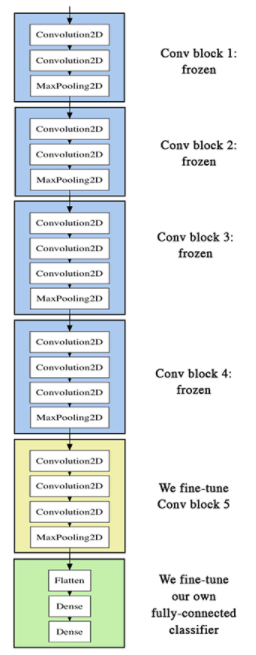

In [ ]:
conv_base.summary()

### 위에서 block 5 부분만 미세조정 하겠다

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

### 학습률을 작게 조정한다 (천천히 학습하도록)
- 미세 조정하는 층에서 학습된 표현을 조금씩 수정하기 위해

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, '--')
plt.plot(epochs, val_acc)
plt.title('Training(--) and validation accuracy')

plt.figure()
plt.plot(epochs, loss,  '--')
plt.plot(epochs, val_loss)
plt.title('Training(--) and validation loss')

## 성능이 92-94%로 1% 정도 향상되었다.
- 주의 할 것은 손실함수는 향상되지 않는 것으로 나타나도, 성능이 향상될 수 있다는 것이다. (분류 성능은 어떤 임계값만 넘으면 활률적으로 개선될 수 있다)
- 정확도에 영향을 미치는 것은 손실값의 분포이지 평균이 아님.
- 지금까지 전체 캐글 경연 데이터의 10%인 2000 개만 사용해서도 높은 성능 결과 없음.

## 요약
- 과대적합을 줄이기 위해서 데이터 확장을 사용
- 전이학습 중 특성 추출방식 소개
- 전이학습 중 미세조정 방식 소개

# Visualizing Convnet Training (교재에는 없음)
- from Deep Learning with Python, by Francois Chollet
- 딥러닝 모델을 '블랙 박스' 같다고 자주 이야기합니다. 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내거나 제시하기 어렵기 때문입니다. 일부 딥러닝 모델에서는 이 말이 어느정도 맞지만 컨브넷에서는 전혀 아닙니다. 컨브넷의 표현은 시각적인 개념을 학습한 것이기 때문에 시각화하기 아주 좋습니다.

### 1. 중간층 활성화

In [17]:
img_path = './cats_and_dogs_filtered/validation/cats/cat.2012.jpg'

# image 를 4D 텐서로
from keras.preprocessing import image

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


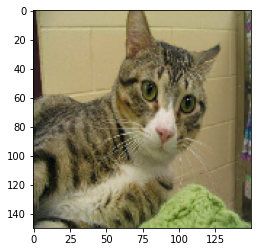

In [18]:
plt.imshow(img_tensor[0])

In [ ]:
from keras import models

In [ ]:
model.layers

In [ ]:
# 상위 8개 층의 출력을 추출합니다:
layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델을 만듭니다:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
# 층의 활성화마다 하나씩 8개의 넘파이 배열로 이루어진 리스트를 반환합니다:
activations = activation_model.predict(img_tensor)

In [ ]:
activations

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

- 
32개의 채널을 가진 148 × 148 크기의 특성 맵입니다. 원본 모델의 첫 번째 층의 활성화 중에서 스무 번째 채널을 그려 보겠습니다:

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')
plt.show()

In [ ]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

### 몇 가지 주목할 내용이 있습니다:

- 첫 번째 층은 여러 종류의 에지 감지기를 모아 놓은 것 같습니다. 이 단계의 활성화에는 초기 사진에 있는 거의 모든 정보가 유지됩니다.
- 상위 층으로 갈수록 활성화는 점점 더 추상적으로 되고 시각적으로 이해하기 어려워집니다. '고양이 귀'와 '고양이 눈'과 같이 고수준의 개념을 인코딩하기 시작합니다. 상위 층의 표현은 이미지의 시각적 콘텐츠에 관한 정보가 점점 줄어들고 이미지의 클래스에 관한 정보가 점점 증가합니다.
- 비어 있는 활성화가 층이 깊어짐에 따라 늘어납니다. 첫 번째 층에서는 모든 필터가 입력 이미지에 활성화되었지만 층을 올라가면서 활성화되지 않는 필터들이 생깁니다. 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않았다는 것을 의미입니다.

### 2. Convnet 필터 시각화

# Exercise (연습)